# 12-13. 프로젝트: 뉴스기사 요약해보기


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


새로운 데이터셋에 대해서 추상적 요약과 추출적 요약을 모두 해보는 시간을 가져봐요.

먼저 주요 라이브러리 버전을 확인해 보죠.

In [ ]:
!pip3 install importlib-metadata

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


- import

In [2]:
import os
import re
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup 

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import AdditiveAttention


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


##### 함수정의

In [3]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens


# 텍스트 비율
def threshold_len(min_len, max_len, nested_list):
  '''범위 안의 길이를 가진 텍스트의 비율을 구하는 함수'''

  cnt = 0
  for s in nested_list:
    if min_len <= len(s.split()) <= max_len:
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이상, %s 이하인 샘플의 비율: %s'%(min_len, max_len, (cnt / len(nested_list))))


# 인퍼런스
def decode_sequence(input_seq):
    '''인퍼런스 단계에서 단어 시퀀스를 완성하는 함수'''

    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq, verbose=0)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c], verbose=0)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence


# 원문 변환
def seq2text(input_seq):
    '''원문의 정수 시퀀스를 텍스트 시퀀스로 변환'''

    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문 변환
def seq2summary(input_seq):
    '''요약문의 정수 시퀀스를 텍스트 시퀀스로 변환'''

    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

## Step 1. 데이터 수집하기


데이터는 아래 링크에 있는 뉴스 기사 데이터(news_summary_more.csv)를 사용하세요.

https://github.com/sunnysai12345/News_Summary

아래의 코드로 데이터를 다운로드할 수 있어요.

In [ ]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [ ]:
data.sample(5)

,headlines,text
47683,PNB has capacity to recover from $1.77 billion...,After PNB detected $1.77 billion worth fraudul...
96665,Jordan used to bet Ã¢ÂÂ¹2 cr on a single golf...,Basketball player Michael Jordan's former USA ...
27931,"In pics: Ranbir, Alia attend Akash Ambani-Shlo...",Ranbir Kapoor along with his mother Neetu Kapo...
17409,Pregnant model goes into labour after walking ...,"Pregnant model Slick Woods, who walked for sin..."
24845,"Math is clear, 2019 polls will be won on Opp'n...",Addressing the Congress Working Committee meet...


이 데이터는 기사의 본문에 해당되는 text와 headlines 두 가지 열로 구성되어져 있습니다.

추상적 요약을 하는 경우에는 text를 본문, headlines를 이미 요약된 데이터로 삼아서 모델을 학습할 수 있어요. 추출적 요약을 하는 경우에는 오직 text열만을 사용하세요.

## Step 2. 데이터 전처리하기 (추상적 요약)


실습에서 사용된 전처리를 참고하여 각자 필요하다고 생각하는 전처리를 추가 사용하여 텍스트를 정규화 또는 정제해 보세요. 만약, 불용어 제거를 선택한다면 상대적으로 길이가 짧은 요약 데이터에 대해서도 불용어를 제거하는 것이 좋을지 고민해 보세요.



#### 데이터 확인 (중복, Null)

In [ ]:
# 데이터 길이확인
len(data)     # 98401

# 중복 확인
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

# text 중복 제거
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))           # 98360

text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280
전체 샘플수 : 98360


In [ ]:
# Null 값 확인
print(data.isnull().sum())   # 없음

headlines    0
text         0
dtype: int64


#### 텍스트 정규화와 불용어 제거

In [ ]:
# 텍스트 정규화와 불용어 제거

contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

print('불용어 개수 :', len(stopwords.words('english') ))
# print(stopwords.words('english'))


정규화 사전의 수:  120
불용어 개수 : 179


불용어를 제거는 Text 전처리 시에서만 호출  
상대적으로 문장 길이가 짧은 headline 전처리할 때는 호출하지 않음.  
  
자연스러운 문장이 되려면 headline에 불용어가 남아 있는 게 더 좋을 것 같기 때문.

In [ ]:
# text 전처리
clean_text = []
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

print("Text 전처리 후 결과: ", clean_text[:5])


Text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [ ]:
# headlines 전처리 (summary로 변수 변경)
clean_summary = []
for s in data['headlines']:
    clean_summary.append(preprocess_sentence(s, remove_stopwords=False))

print("headline 전처리 후 결과: ", clean_summary[:5])

headline 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


- 다시 한번 empty 샘플 확인

보다 쉽게 확인하기 위해 데이터들을 데이터프레임에 재저장  
empty 샘플은 모두 Null 값을 가진 샘플로 대체.

In [ ]:
data['text'] = clean_text
data['headlines'] = clean_summary

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [ ]:
# Null 값 확인
print(data.isnull().sum())

# Null 값 제거
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

headlines    0
text         0
dtype: int64
전체 샘플수 : 98360


- backup 파일 저장하기

In [ ]:
# df 저장(backup)
data_path = '/content/drive/MyDrive/Colab Notebooks/Exploration/news_summarization/data'
data.to_csv(data_path+"/data_news_summa.csv")

In [4]:
# df 불러오기
data_path = '/content/drive/MyDrive/Colab Notebooks/Exploration/news_summarization/data'
data = pd.read_csv(data_path+"/data_news_summa.csv")

#### 훈련데이터와 테스트데이터 나누기

- 샘플의 최대 길이 정하기

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


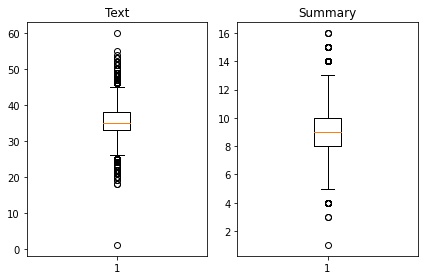

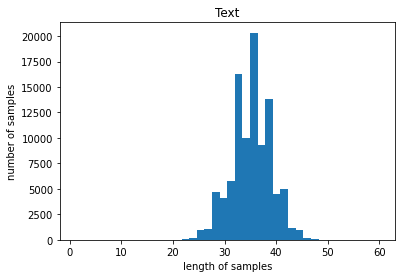

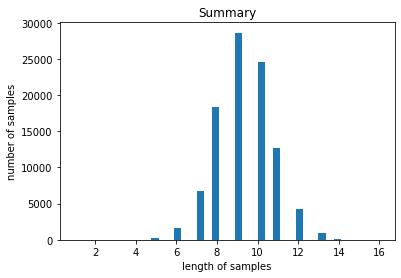

In [5]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
summary_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('Summary')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

텍스트의 길이가 잘 분산된 모양임.  
text의 경우 '20-50'에 분포되어 있고, summary는 '5-15' 사이에 분포.  
-> 최소길이와 최대길이를 정해서 잘라 주는 것이 좋을 것 같음.

In [6]:
text_min_len = 25
text_max_len = 42
summary_min_len = 7
summary_max_len = 12

threshold_len(text_min_len, text_max_len, data['text'])
threshold_len(summary_min_len, summary_max_len,  data['headlines'])

전체 샘플 중 길이가 25 이상, 42 이하인 샘플의 비율: 0.9726616510776739
전체 샘플 중 길이가 7 이상, 12 이하인 샘플의 비율: 0.9683712891419276


거의 모든 데이터가 이 범위에 존재함.

In [7]:
# 위 범위 내의 데이터로 정제
data = data[data['text'].apply(lambda x: text_min_len <= len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: summary_min_len <= len(x.split()) <= summary_max_len)]
print('전체 샘플수 :', (len(data)))   # 92638

전체 샘플수 : 92638


#### 시작 토큰과 종료 토큰 추가하기

In [8]:
# 요약 데이터에 시작 토큰과 종료 토큰 추가

data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head(5)

,Unnamed: 0,headlines,text,decoder_input,decoder_target
0,0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
2,2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
6,6,india get all out for their lowest odi total i...,india recorded lowest odi total new zealand ge...,sostoken india get all out for their lowest od...,india get all out for their lowest odi total i...


- Numpy 타입으로 저장

In [9]:
encoder_input = np.array(data['text'])            # 인코더의 입력
decoder_input = np.array(data['decoder_input'])   # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 타겟

- 훈련 데이터와 테스트 데이터 분리

In [10]:
# indices shuffle
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)

encoder_input = encoder_input[indices]      # encoder input
decoder_input = decoder_input[indices]      # decoder input
decoder_target = decoder_target[indices]    # decoder target

In [11]:
# 20% test data
n_of_val = int(len(encoder_input)*0.2)

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 74111
훈련 레이블의 개수 : 74111
테스트 데이터의 개수 : 18527
테스트 레이블의 개수 : 18527


#### 정수 인코딩

- 단어 집합(vocabulary) 만들기

In [12]:
src_tokenizer = Tokenizer()                     # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [13]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

- 빈도수가 낮은 단어들은 훈련 데이터에서 제외

In [14]:
threshold = 20
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 미만인 희귀 단어의 수: %s'%(threshold, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 66981
등장 빈도가 20번 미만인 희귀 단어의 수: 54940
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 12041
단어 집합에서 희귀 단어의 비율: 82.02326032755558
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 7.743332568227713


In [15]:
# 등장 빈도가 20 회 미만인 단어들은 정수 인코딩 과정에서 빼고, 훈련 데이터에서 제거
src_vocab = 12000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 12000 개로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

In [16]:
# 텍스트 시퀀스를 정수 시퀀스로 변환(encoder)
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

- 빈도수가 낮은 단어들은 테스트 데이터에서 제외

In [17]:
threshold = 12
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 미만인 희귀 단어의 수: %s'%(threshold, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 29293
등장 빈도가 12번 미만인 희귀 단어의 수: 22663
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 6630
단어 집합에서 희귀 단어의 비율: 77.36660635646741
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 8.4465647507645


In [18]:
# 등장 빈도가 8회 미만인 단어들은 정수 인코딩 과정에서 빼고, 훈련 데이터에서 제거

tar_vocab = 6500
tar_tokenizer = Tokenizer(num_words=tar_vocab)    # 단어 집합의 크기를 8500개로 제한
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환 (decoder)
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

- 데이터에서 요약문의 길이가 1인 경우의 인덱스를 찾고 이 샘플들을 모두 삭제

In [19]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))    # 없음.

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))   

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 74111
훈련 레이블의 개수 : 74111
테스트 데이터의 개수 : 18527
테스트 레이블의 개수 : 18527


- 패딩하기

In [20]:
# post padding 
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')

## Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)


일반적인 seq2seq보다는 어텐션 메커니즘을 사용한 seq2seq를 사용하는 것이 더 나은 성능을 얻을 수 있어요. 실습 내용을 참고하여 어텐션 메커니즘을 사용한 seq2seq를 설계해 보세요.



##### 인코더 설계

In [21]:
# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
# encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
# encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

##### 디코더 설계

In [22]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

- 중간 모델

In [23]:
# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 42)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 42, 128)      1536000     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 42, 256),    394240      ['embedding[0][0]']              
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                              

##### 어텐션 메커니즘 : Bahdanau 스타일

In [24]:
# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

- 최종 모델

In [25]:
# 최종 모델
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 42)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 42, 128)      1536000     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 42, 256),    394240      ['embedding[0][0]']              
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                            

##### 모델 훈련

In [26]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)      # early stop
history = model.fit(  x=[encoder_input_train, decoder_input_train]
                    , y=decoder_target_train
                    , validation_data=([encoder_input_test, decoder_input_test]
                                       , decoder_target_test)
                    , batch_size=256
                    , callbacks=[es]
                    , epochs=50
                  )

Epoch 1/50
290/290 [==============================] - 162s 519ms/step - loss: 5.4404 - val_loss: 5.0731
Epoch 2/50
290/290 [==============================] - 148s 510ms/step - loss: 4.9736 - val_loss: 4.7285
Epoch 3/50
290/290 [==============================] - 149s 515ms/step - loss: 4.5184 - val_loss: 4.2874
Epoch 4/50
290/290 [==============================] - 148s 512ms/step - loss: 4.1331 - val_loss: 4.0205
Epoch 5/50
290/290 [==============================] - 148s 510ms/step - loss: 3.8555 - val_loss: 3.8235
Epoch 6/50
290/290 [==============================] - 147s 508ms/step - loss: 3.6291 - val_loss: 3.6783
Epoch 7/50
290/290 [==============================] - 147s 507ms/step - loss: 3.4445 - val_loss: 3.5783
Epoch 8/50
290/290 [==============================] - 146s 503ms/step - loss: 3.2898 - val_loss: 3.4972
Epoch 9/50
290/290 [==============================] - 146s 503ms/step - loss: 3.1589 - val_loss: 3.4455
Epoch 10/50
290/290 [==============================] - 148s 509m

##### 훈련 시각화

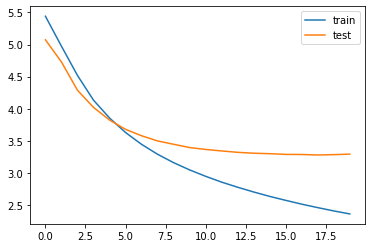

In [27]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)


원래의 요약문(headlines 열)과 학습을 통해 얻은 추상적 요약의 결과를 비교해 보세요.



##### 사전 준비

In [28]:
# 사전
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [29]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [30]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

##### 실제 결과와 비교

In [31]:
AbsSum = []

for i in range(0, 10):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    temp = decode_sequence(encoder_input_test[i].reshape(1, text_max_len))
    print("예측 요약 :", temp)
    AbsSum.append(temp)
    print("\n")

원문 : delhi court friday acquitted man accused raping woman pretext marriage saying educated independent woman knows entering physical relations even woman entered sexual relations accused pretext marriage fall category rape court added 
실제 요약 : woman knows of sexual relations court 
예측 요약 :  man accused of raping woman to marry woman in law


원문 : pacer shardul thakur slammed runs balls srh help csk qualify seventh ipl final smashed six sixes year old become first cricketer achieve feat harris shield school tournament mumbai thakur made balls match 
실제 요약 : csk thakur had once hit six sixes in an over 
예측 요약 :  pacer posts first ever hat trick in ipl match


원문 : us president donald trump said despite tough stance trade india called said wants trade deal country going wait little india wants deal soon trump added notably us leader past accused india imposing tariffs us products 
실제 요약 : india called and said it wants trade deal with us trump 
예측 요약 :  india will not be able to trade wa

## Step 5. Summa을 이용해서 추출적 요약해보기


추상적 요약은 추출적 요약과는 달리 문장의 표현력을 다양하게 가져갈 수 있지만, 추출적 요약에 비해서 난이도가 높아요. 반대로 말하면 추출적 요약은 추상적 요약에 비해 난이도가 낮고 기존 문장에서 문장을 꺼내오는 것이므로 잘못된 요약이 나올 가능성이 낮아요.



In [32]:
!pip install summa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 54 kB 2.7 MB/s 
  Created wheel for summa: filename=summa-1.2.0-py3-none-any.whl size=54412 sha256=988976de3baffdcb8bc688a6a210c8013492d1bf41a45435f2f1ddc0c20d30ab
  Stored in directory: /root/.cache/pip/wheels/29/64/ac/7b443477588d365ef37ada30d456bdf5f07dc5be9f6324cb6e
Successfully built summa


- import

In [33]:
import requests
from summa.summarizer import summarize
from summa import keywords

- 데이터 준비

In [34]:
import requests
from summa.summarizer import summarize
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data2 = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
data2.head(10)



,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...
5,Rahat Fateh Ali Khan denies getting notice for...,Pakistani singer Rahat Fateh Ali Khan has deni...
6,"India get all out for 92, their lowest ODI tot...",India recorded their lowest ODI total in New Z...
7,Govt directs Alok Verma to join work 1 day bef...,Weeks after ex-CBI Director Alok Verma told th...
8,Called PM Modi 'sir' 10 times to satisfy his e...,Andhra Pradesh CM N Chandrababu Naidu has said...
9,"Cong wins Ramgarh bypoll in Rajasthan, takes t...",Congress candidate Shafia Zubair won the Ramga...


- 결과 출력 : 단어수로 제한

In [35]:
for idx, (head, txt) in enumerate(zip(data2['headlines'], data2['text'])):
    if idx == 10:
        break
    print("원문 :", txt)
    print("실제 요약 :", head)
    print("추출적 요약 :", summarize(txt, words=15))
    print("\n")

원문 : Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.
실제 요약 : upGrad learner switches to career in ML & Al with 90% salary hike
추출적 요약 : upGrad's Online Power Learning has powered 3 lakh+ careers.


원문 : Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.
실제 요약 : Delhi techie wins free food from Swiggy for one year on CRED
추출적 요약 : Users get one CRED coin per rupee of bill p

### 고찰

Extraction vs. Abstraction

| |Extractive 요약|Abstractive 요약|
|:-----------------------|---------------------------:|---------------------:|
| 문법 완성도 |상대적 완성도 높음| 문법 완성도 낮음  |
| 핵심던어 포함  |  핵심단어를 잘 포함 |학습에 따라 핵심단어 포함 정도가 다름|
|비고 |text의 앞 뒤 문장 중 일부를 잘라 표현하는 경향이 큼|전체적으로 모델과 학습에 영향을 많이 받음|


- 모델이 좀 더 정교하고 학습이 잘 이뤄진다면 extractive 요약보다 abstractive 요약이 더 효과적일 가능성이 높아 보입니다. 
- extractive 요약은 문장 완성도가 높지만, 있는 단어나 문장을 짜집기 한 느낌의 요약인 반면, abstraction 요약은 본문에 나오지 않는 단어를 창의적(?)으로 사용할 수 있다는 점에서 큰 점수를 주고 싶습니다.
- 비록 영어 문장만을 해 봤지만, 신기하고 흥미로웠습니다.